# Import librairies

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
#pip install chart_studio numpy pandas matplotlib joblib keras tensorflow scikit-learn plotly seaborn statsmodels scipy

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [4]:
dataframe = pd.read_csv('dataframe.csv')

In [5]:
dataframe.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [6]:
data = dataframe.values  # Converte o DataFrame para um array NumPy

## Train test split

In [7]:
# # Definindo a proporção para treino, validação e teste
# train_size = 0.7
# valid_size = 0.15
# test_size = 0.15

In [8]:
# # Total de dados
# total_data_len = len(dataframe)
# train_data_len = int(np.floor(total_data_len * train_size))
# valid_data_len = int(np.floor(total_data_len * valid_size))
# test_data_len = int(np.floor(total_data_len * test_size))
# print(total_data_len)
# print(train_data_len)
# print(valid_data_len)
# print(test_data_len)


### Criando Treino, Validacao e Teste sem Padronizacao dos dados

In [9]:
# # Criando conjuntos de treinamento
# train_data = data[0:train_data_len, :]
# X_train, Y_train = [], []
# for i in range(60, len(train_data)):
#     X_train.append(train_data[i-60:i, 0])
#     Y_train.append(train_data[i, 0])

# X_train, Y_train = np.array(X_train), np.array(Y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# print(len(X_train))
# print(len(Y_train))
# print(len(train_data))

In [10]:
# # Criando o conjunto de validação
# valid_data = data[train_data_len:train_data_len + valid_data_len, :]
# X_valid, Y_valid = [], []

# for i in range(60, len(valid_data)):
#     X_valid.append(valid_data[i-60:i, 0])
#     Y_valid.append(valid_data[i, 0])

# X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
# X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
# Y_valid = np.array(Y_valid)

# print(len(X_valid))
# print(len(Y_valid))
# print(len(valid_data))

In [11]:
# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
# Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

# X_test = []
# for i in range(60, len(test_data)):
#     X_test.append(test_data[i-60:i, 0])

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
# print(len(Y_test))
# print(len(test_data))

### Treino, Teste e Validacao com padronizacao dos dados

In [12]:
# # Criando o escalador
# scaler = MinMaxScaler()


# # Salvar o scaler para uso posterior
# joblib.dump(scaler, 'scaler.pkl')


In [13]:
# # Ajustar o scaler com base no conjunto de treinamento
# train_data = data[0:train_data_len, :]  # Apenas dados de treino
# train_data_scaled = scaler.fit_transform(train_data)  # Padronizando o conjunto de treino

# # Criando os conjuntos de treinamento a partir dos dados padronizados
# X_train, Y_train = [], []
# for i in range(60, len(train_data_scaled)):
#     X_train.append(train_data_scaled[i-60:i, 0])  # Sequência de 60 passos
#     Y_train.append(train_data_scaled[i, 0])       # Próximo valor a ser previsto

# # Convertendo para arrays NumPy
# X_train, Y_train = np.array(X_train), np.array(Y_train)

# # Ajustando o formato de X_train para 3D, se necessário (séries temporais)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# # Verificando os tamanhos
# print(f"Tamanhos: X_train={len(X_train)}, Y_train={len(Y_train)}, train_data={len(train_data)}")


In [14]:
# # Criando o conjunto de validação
# valid_data = data[train_data_len:train_data_len + valid_data_len, :]  # Dados de validação

# # Padronizando o conjunto de validação com o escalador treinado no conjunto de treino
# valid_data_scaled = scaler.transform(valid_data)  # Usando o mesmo escalador

# # Criando as sequências para o conjunto de validação
# X_valid, Y_valid = [], []
# for i in range(60, len(valid_data_scaled)):
#     X_valid.append(valid_data_scaled[i-60:i, 0])  # Sequência de 60 passos
#     Y_valid.append(valid_data_scaled[i, 0])       # Próximo valor a ser previsto

# # Convertendo para arrays NumPy
# X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

# # Ajustando o formato de X_valid para 3D, se necessário
# X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

# # Verificando os tamanhos
# print(f"Tamanhos: X_valid={len(X_valid)}, Y_valid={len(Y_valid)}")

In [15]:
# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Dados de teste

# # Padronizando o conjunto de teste com o escalador ajustado no conjunto de treino
# test_data_scaled = scaler.transform(test_data)  # Usando o mesmo escalador

# # Criando as sequências para o conjunto de teste
# X_test = []
# for i in range(60, len(test_data_scaled)):
#     X_test.append(test_data_scaled[i-60:i, 0])  # Sequência de 60 passos

# X_test = np.array(X_test)

# # Ajustando o formato de X_test para 3D, necessário para o modelo LSTM
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# # Definindo Y_test (valores reais do conjunto de teste)
# Y_test = data[train_data_len + valid_data_len:, :]  # Isso permanece o mesmo

# print(f"Tamanhos: X_test={len(X_test)}, Y_test={len(Y_test)}")
# print(f"Tamanho de test_data: {len(test_data)}")

In [16]:
# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Dados de teste

# # Padronizando o conjunto de teste com o escalador ajustado no conjunto de treino
# test_data_scaled = scaler.transform(test_data)  # Usando o mesmo escalador


# X_test, Y_test = [], []
# for i in range(60, len(test_data)):
#     X_test.append(test_data_scaled[i-60:i, 0])  # Sequência de 60 passos
#     Y_test.append(test_data_scaled[i, 0])       # Próximo valor a ser previsto


# X_test = np.array(X_test), np.array(Y_test)


# print(f"Tamanhos: X_test={len(X_test)}, Y_test={len(Y_test)}")
# print(f"Tamanho de test_data: {len(test_data)}")

# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
# Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

# X_test = []
# for i in range(60, len(test_data)):
#     X_test.append(test_data[i-60:i, 0])

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
# print(len(Y_test))
# print(len(test_data))

In [17]:
# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
# Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

# X_test = []
# for i in range(60, len(test_data)):
#     X_test.append(test_data[i-60:i, 0])

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
# print(len(Y_test))
# print(len(test_data))

### Padronização do Treino, Validação e Teste

In [18]:
# Definir o número de passo
n_steps_in = 10
n_steps_out = 1

In [19]:
# Transformar de Series Temporais para Amostras e Saída
def create_supervised_data(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in, 0])  
        Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, 0]) 
    return np.array(X), np.array(Y)

In [20]:
# Definindo a proporção para treino, validação e teste
train_prop = 0.7
valid_prop = 0.15
test_prop = 0.15

In [21]:
# Padronizar o conjunto de treino
scaler = MinMaxScaler(feature_range=(0, 1))

In [22]:
# Definir proporção de treino
train_size = int(len(data) * train_prop)

# Dividir o conjunto de treino
train_data = data[:train_size]

train_scaled = scaler.fit_transform(train_data)

X_train, Y_train = create_supervised_data(train_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de treino
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (384, 10)
Y_train shape: (384, 1)


In [23]:
valid_size = int(len(data) * valid_prop)

# Dividir o conjunto de validação
valid_data = data[train_size:train_size + valid_size]

# Padronizar o conjunto de validação (usando parâmetros do treino)
valid_scaled = scaler.transform(valid_data)

# Criar dados supervisionados para validação
X_valid, Y_valid = create_supervised_data(valid_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de validação
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)


X_valid shape: (74, 10)
Y_valid shape: (74, 1)


In [24]:
# O restante dos dados será usado para teste
test_data = data[train_size + valid_size:]

# Padronizar o conjunto de teste (usando parâmetros do treino)
test_scaled = scaler.transform(test_data)

# Criar dados supervisionados para teste
X_test, Y_test = create_supervised_data(test_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de teste
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_test shape: (76, 10)
Y_test shape: (76, 1)


### Tamanho do Dataframe Treino, Teste e Validação

In [25]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'Y_valid length: {len(Y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 384
Y_train length: 384
X_valid length: 74
Y_valid length: 74
X_test length: 76
Y_test length: 76


## Ajuste dos dados para os modelos LSTM e CNN

In [26]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (384, 10, 1)
Validation set shape (74, 10, 1)
Test set shape (76, 10, 1)


In [27]:
# def create_sequences(data, seq_length):
#     sequences = []
#     labels = []
#     for i in range(len(data) - seq_length):
#         sequence = data[i:i+seq_length]
#         label = data[i+seq_length]
#         sequences.append(sequence)
#         labels.append(label)
#     return np.array(sequences), np.array(labels)

# # Defina o comprimento da sequência
# seq_length = 30
# X_train_series, Y_train_series = create_sequences(scaled_data, seq_length)
# print('Train set shape', X_trains_series.shape)
# print('Validation set shape', X_valid.shape)
# print('Test set shape', X_test.shape)

# Funções de Métricas Utilizadas e Plot dos Resultados

In [28]:
# # Função para calcular MAPE
# def mean_absolute_percentage_error(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
# # Função para calcular MSE
# def mean_squared_error(y_true, y_pred):
#     return np.mean((y_true - y_pred) ** 2)


In [30]:
# # Função para calcular RMSE
# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [31]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)

    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return mae, mse, rmse, mape

In [32]:
# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta

    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]

        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")

        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")

        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")

        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

In [33]:
def plot_multiple_loss(history_standard, history_reg, history_drop, history_reg_drop):

    # Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(history_standard.history['loss'], label='Treinamento')
    plt.plot(history_standard.history['val_loss'], label='Validação')
    plt.title('Modelo Simples: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(history_reg.history['loss'], label='Treinamento')
    plt.plot(history_reg.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(history_drop.history['loss'], label='Treinamento')
    plt.plot(history_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(history_reg_drop.history['loss'], label='Treinamento')
    plt.plot(history_reg_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [34]:
def plot_predicts(y_pred, y_pred_reg, y_pred_drop, y_pred_reg_drop):

    # Gráficos de predição
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred, label='Predito (Simples)', color='red')
    plt.title('Modelo Simples')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg, label='Predito (Reg)', color='red')
    plt.title('Modelo com Regularização')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_drop, label='Predito (Drop)', color='red')
    plt.title('Modelo com Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg_drop, label='Predito (Reg + Drop)', color='red')
    plt.title('Modelo com Regularização e Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [35]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [36]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [37]:
#history_mlp = model_mlp.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp = model_mlp.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_mlp,
                            batch_size=batch_mlp,
                            verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0874 - val_loss: 0.0384
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346 - val_loss: 0.0197
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0189 - val_loss: 0.0179
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0129
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_l

### Implementacao e Ajuste do Modelo MLP com regularização

In [38]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1],
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [39]:
#history_mlp_reg = model_mlp_reg.fit(X_train, Y_train,
#                           validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_reg = model_mlp_reg.fit(X_train,
                                    Y_train,
                                    validation_data=(X_valid, Y_valid),
                                    epochs=epochs_mlp,
                                    batch_size=batch_mlp,
                                    verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.7805 - val_loss: 0.6002
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5947 - val_loss: 0.5373
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5218 - val_loss: 0.4783
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4642 - val_loss: 0.4276
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4167 - val_loss: 0.3865
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3760 - val_loss: 0.3498
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3404 - val_loss: 0.3166
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3084 - val_loss: 0.2869
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2800 - val_loss: 0.2605
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2544 - val_loss: 0.2369
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2316 - val_loss: 0.2158
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2111 - val_l

### Implementacao e ajuste do modelo MLP com Dropout

In [40]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(32, activation='relu'))
model_mlp_drop.add(Dropout(0.3))
model_mlp_drop.add(Dense(1))
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [41]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train,
                                        Y_train,
                                        validation_data=(X_valid, Y_valid),
                                        epochs=epochs_mlp,
                                        batch_size=batch_mlp,
                                        verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4156 - val_loss: 0.1334
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1894 - val_loss: 0.0780
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1214 - val_loss: 0.0435
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1168 - val_loss: 0.0256
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0764 - val_loss: 0.0270
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0600 - val_loss: 0.0200
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0573 - val_loss: 0.0235
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0496 - val_loss: 0.0247
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0497 - val_loss: 0.0237
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0473 - val_loss: 0.0250
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0418 - val_loss: 0.0247
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0341 - val_l

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [42]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.3))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [43]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train,
                                              Y_train,
                                              validation_data=(X_valid, Y_valid),
                                              epochs=epochs_mlp,
                                              batch_size=batch_mlp,
                                              verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4928 - mae: 0.5285 - val_loss: 0.1756 - val_mae: 0.2179
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2163 - mae: 0.2670 - val_loss: 0.1228 - val_mae: 0.1472
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1471 - mae: 0.1976 - val_loss: 0.1220 - val_mae: 0.1576
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1333 - mae: 0.1790 - val_loss: 0.0953 - val_mae: 0.0983
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1185 - mae: 0.1541 - val_loss: 0.0944 - val_mae: 0.1113
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1160 - mae: 0.1614 - val_loss: 0.0864 - val_mae: 0.0983
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1086 - mae: 0.1587 - val_loss: 0.0830 - val_mae: 0.0995
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1025 - mae: 0.1544 - val_loss: 0.0798 - val_mae: 0.0995
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0932 - mae:

## Comparando os 4 modelos

In [44]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Modelo Padrão:
MAE: 0.0821
MSE: 0.0110
RMSE: 0.1047
MAPE: 18.0009%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Modelo com Regularização:
MAE: 0.0943
MSE: 0.0147
RMSE: 0.1213
MAPE: 19.4806%
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001ADF24D9080> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━

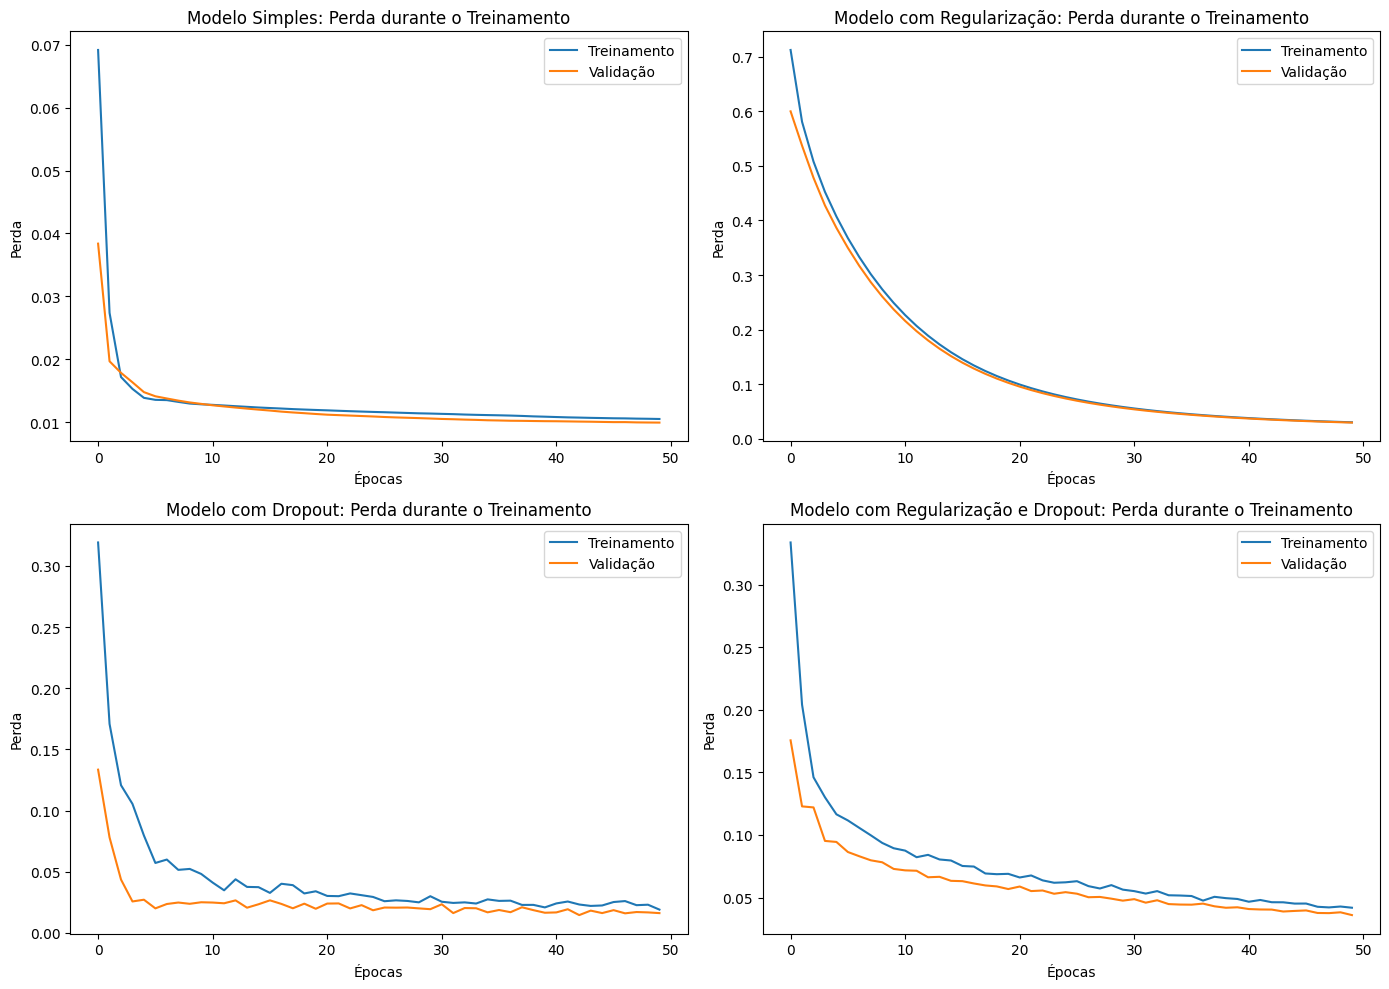

In [45]:
#Plot do Grafico de Perda
plot_multiple_loss(history_mlp, history_mlp_reg, history_mlp_drop, history_mlp_reg_drop)

In [46]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


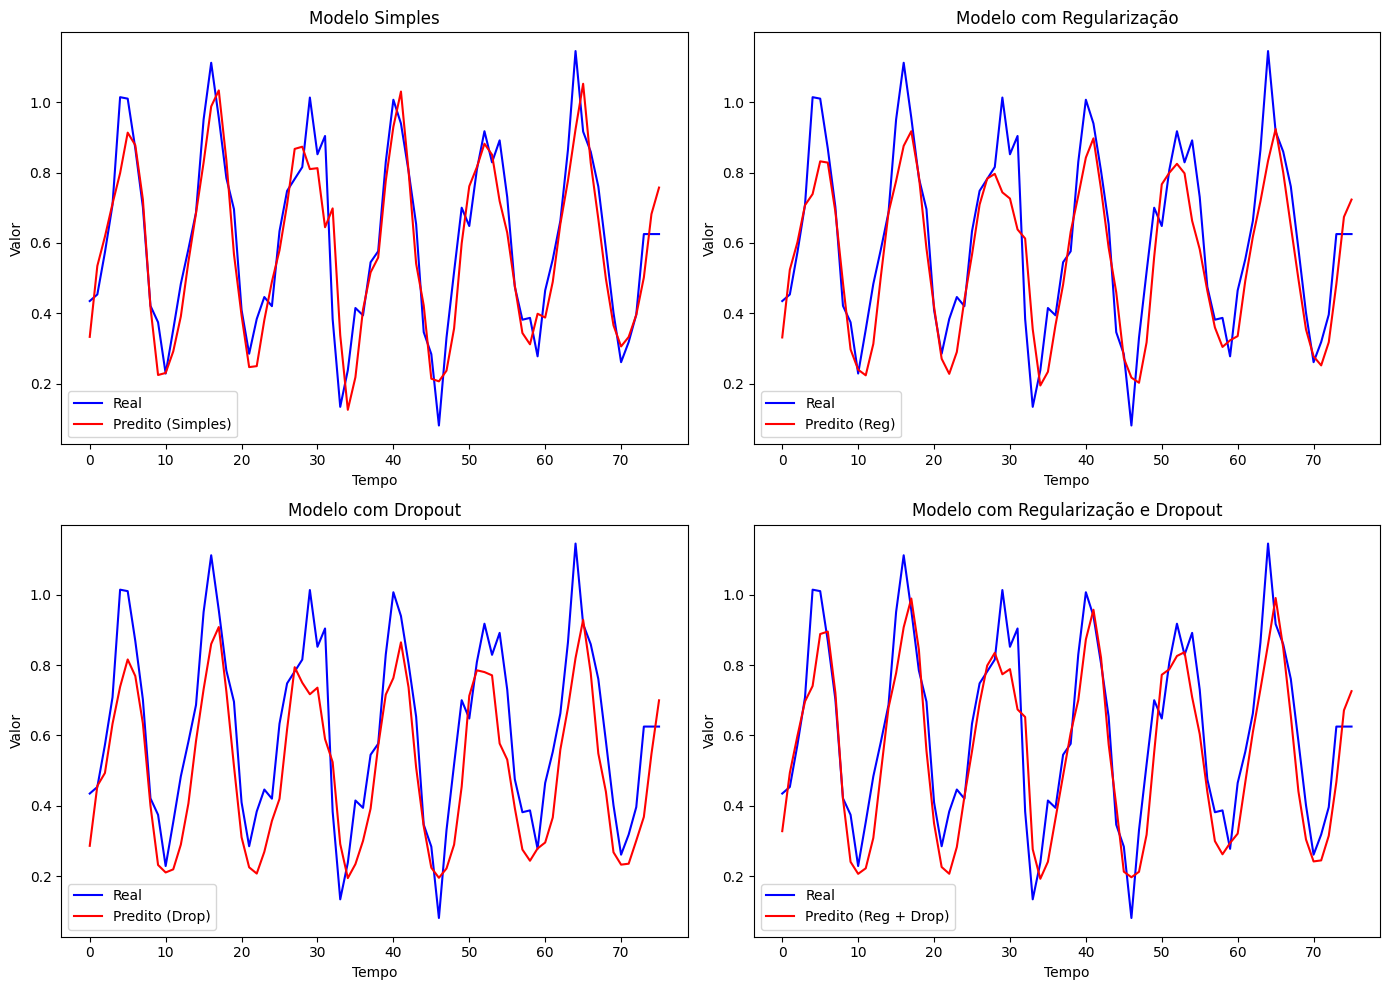

In [47]:
plot_predicts(y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop)

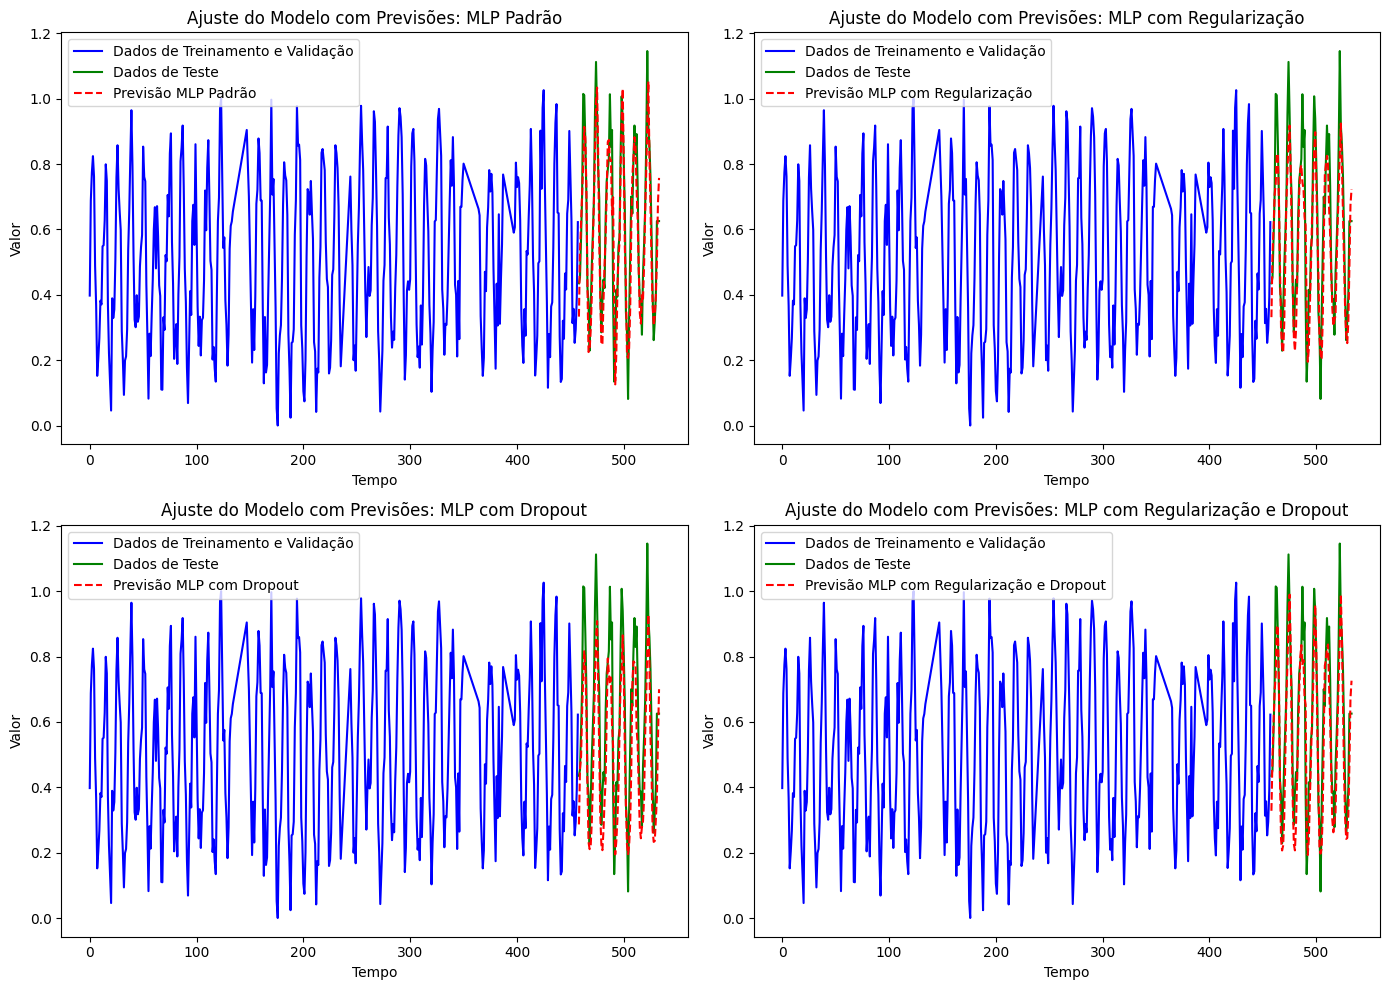

In [48]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [49]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
#adam = optimizers.Adam(lr)


## Implementando e Ajustando Modelo CNN

In [50]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [51]:
#history_cnn = model_cnn.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn = model_cnn.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_cnn,
                            batch_size=batch_cnn,
                            verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2274 - val_loss: 0.0914
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1019 - val_loss: 0.0699
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0701 - val_loss: 0.0545
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0516 - val_loss: 0.0398
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0375 - val_loss: 0.0314
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 - val_loss: 0.0252
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - val_loss: 0.0233
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_loss: 0.0223
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - val_loss: 0.0219
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - val_loss: 0.0215
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - val_loss: 0.0212
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0178 - val_

## Implementando e Ajustando Modelo CNN com Regularização L2

In [52]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [53]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.0620 - val_loss: 0.8067
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7847 - val_loss: 0.6510
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6239 - val_loss: 0.5259
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5022 - val_loss: 0.4202
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4040 - val_loss: 0.3419
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3275 - val_loss: 0.2785
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2678 - val_loss: 0.2307
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2218 - val_loss: 0.1933
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1859 - val_loss: 0.1638
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1582 - val_loss: 0.1410
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1366 - val_loss: 0.1230
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1196 - val_l

## Implementando e Ajustando Modelo CNN com Dropout

In [54]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.3))
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_drop.summary()

In [55]:
#history_cnn_drop = model_cnn_drop.fit(X_train_series, Y_train,
#                                       validation_data=(X_valid_series, Y_valid),
#                                       epochs=epochs_cnn,
#                                       verbose=2)

history_cnn_drop = model_cnn_drop.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.2164 - val_loss: 0.0896
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1096 - val_loss: 0.0634
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0678 - val_loss: 0.0395
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0510 - val_loss: 0.0308
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0438 - val_loss: 0.0241
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0345 - val_loss: 0.0273
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0320 - val_loss: 0.0229
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0337 - val_loss: 0.0242
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0297 - val_loss: 0.0238
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0342 - val_loss: 0.0251
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0314 - val_loss: 0.0233
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0340 - val_

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [56]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(0.3))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg_drop.summary()

In [57]:
#history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series, Y_train,
#                                             validation_data=(X_valid_series, Y_valid),
#                                             epochs=epochs_cnn,
#                                             verbose=2)

history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series,
                                            Y_train,
                                            validation_data=(X_valid_series, Y_valid),
                                            epochs=epochs_cnn,
                                            batch_size=batch_cnn,
                                            verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0393 - val_loss: 0.8014
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7941 - val_loss: 0.6510
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6385 - val_loss: 0.5328
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5188 - val_loss: 0.4332
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4332 - val_loss: 0.3578
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3595 - val_loss: 0.2939
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3034 - val_loss: 0.2500
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2472 - val_loss: 0.2072
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2124 - val_loss: 0.1798
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1798 - val_loss: 0.1531
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1592 - val_loss: 0.1352
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1422 - val_l

## Comparando os 4 Modelos CNN

In [58]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [59]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo Padrão:
MAE: 0.0984
MSE: 0.0163
RMSE: 0.1277
MAPE: 20.5714%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Modelo com Regularização:
MAE: 0.1332
MSE: 0.0269
RMSE: 0.1640
MAPE: 25.8628%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Dropout:
MAE: 0.1087
MSE: 0.0198
RMSE: 0.1407
MAPE: 21.7632%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Regularização e Dropout:
MAE: 0.1362
MSE: 0.0280
RMSE: 0.1672
MAPE: 25.5656%


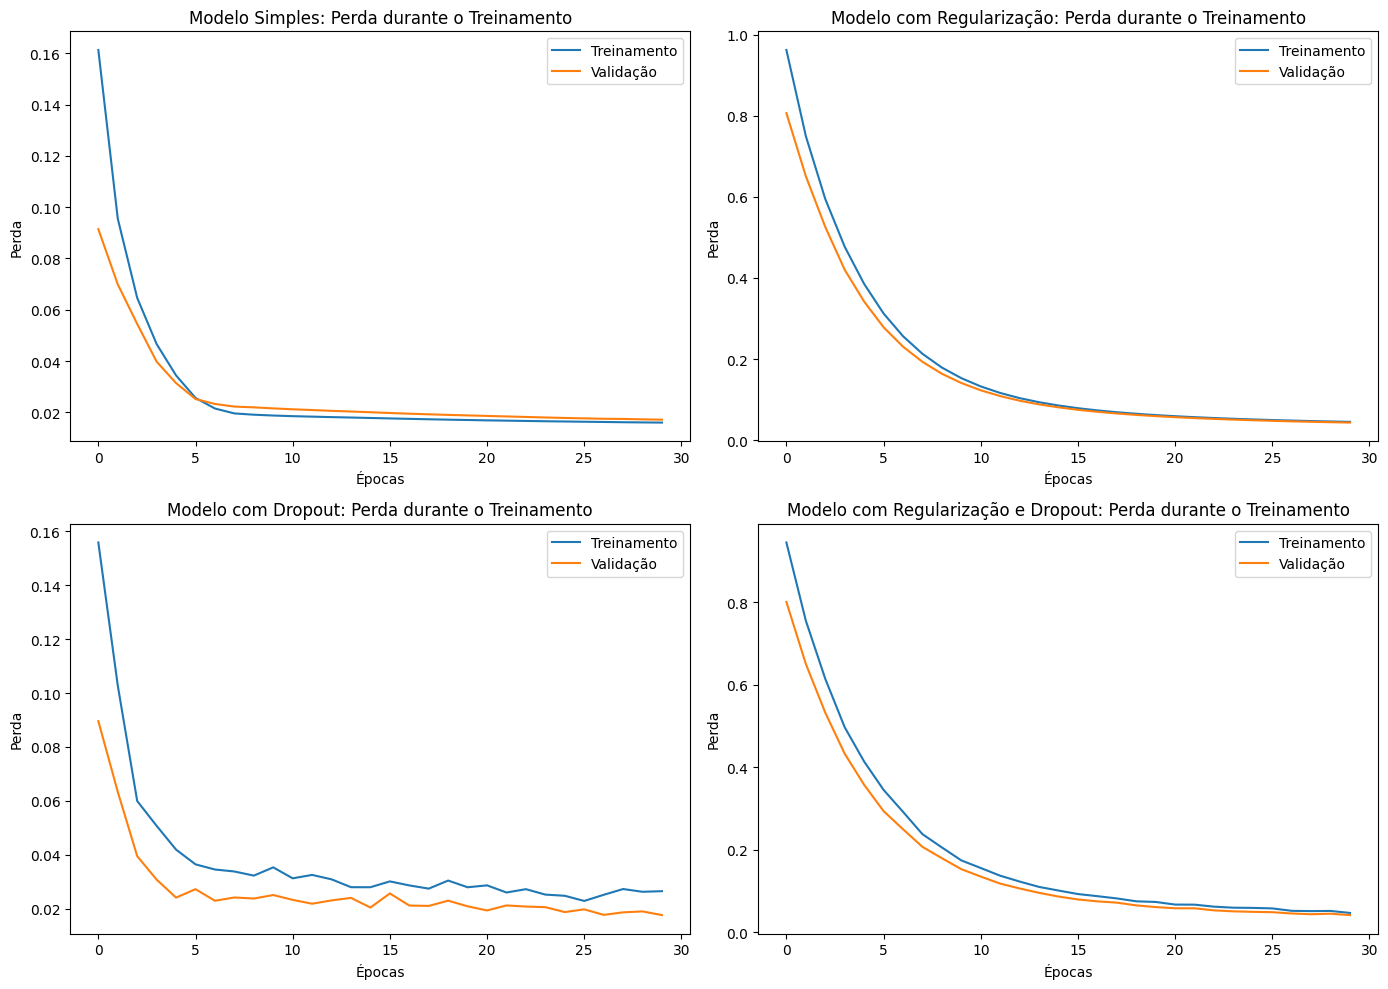

In [60]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn, history_cnn_reg, history_cnn_drop, history_cnn_reg_drop)

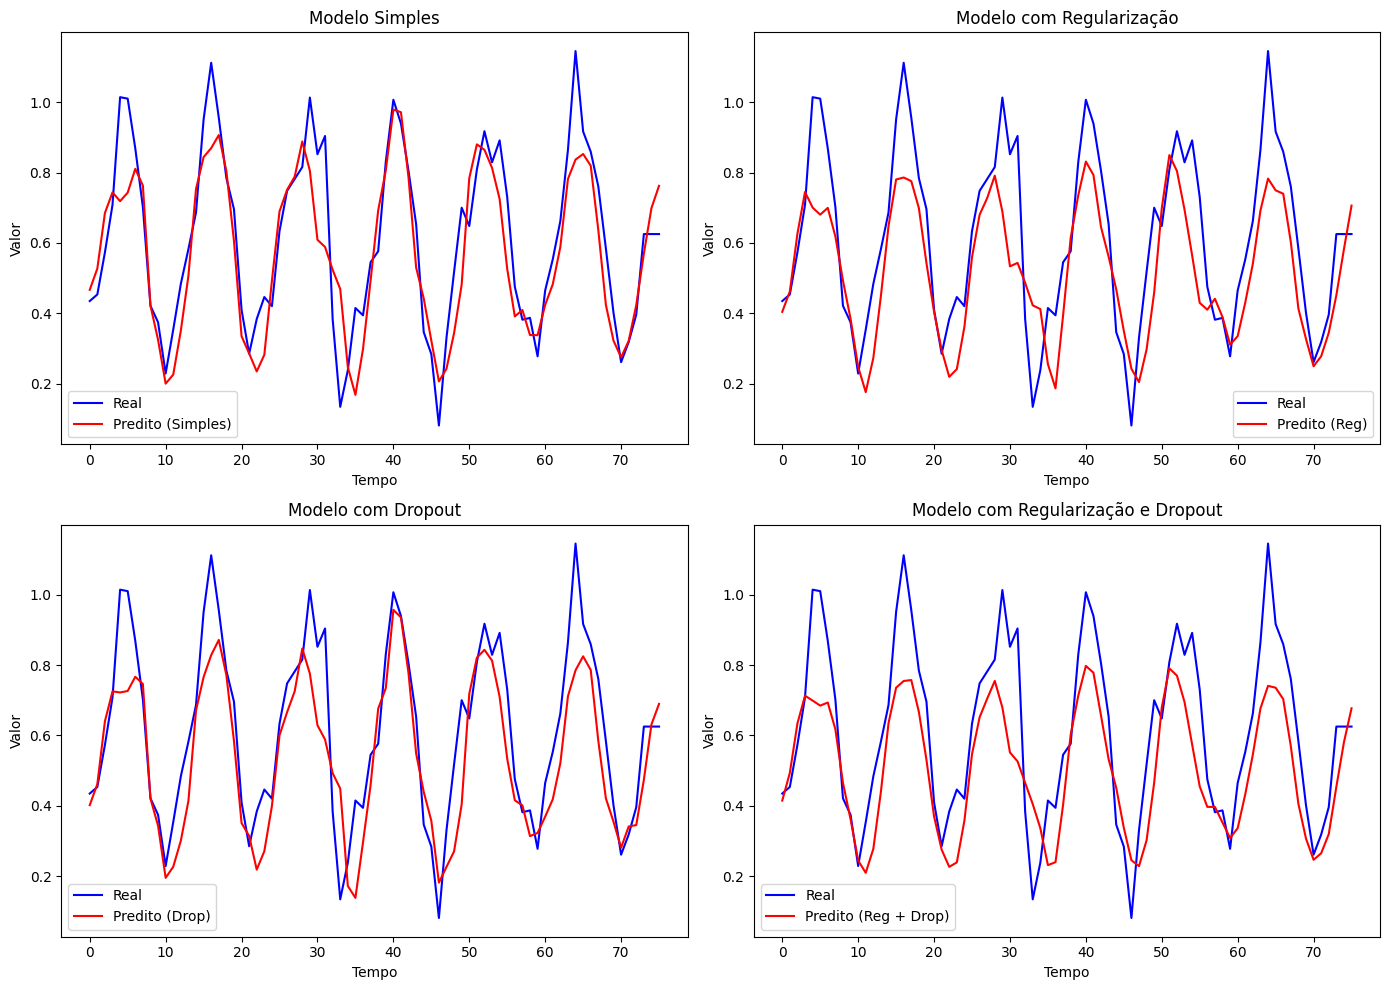

In [61]:
plot_predicts(y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop)

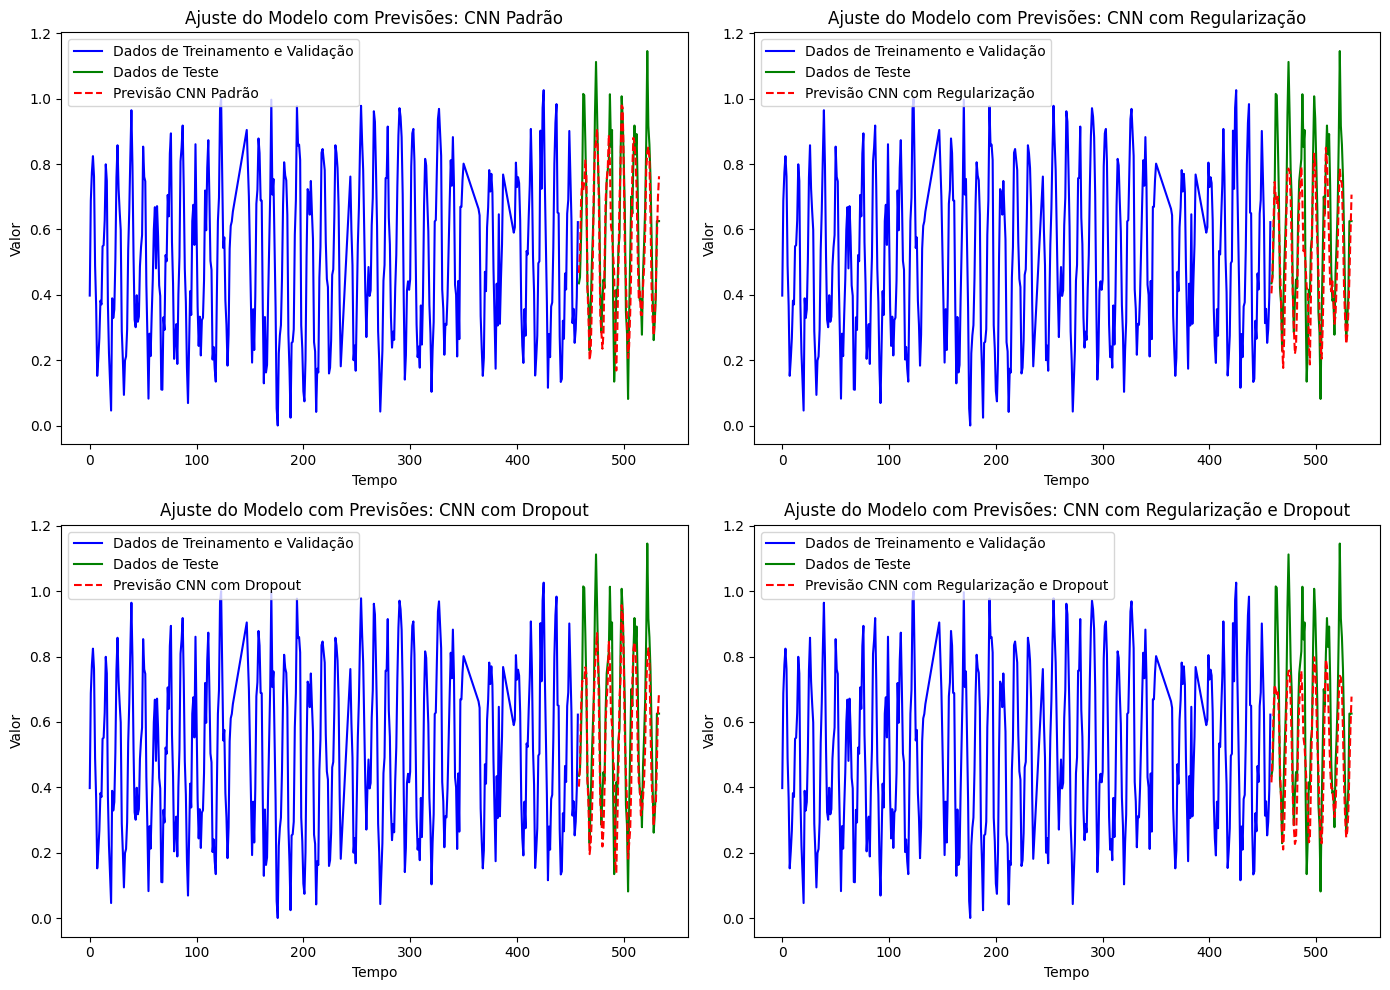

In [62]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [63]:
#Hiperparametros
epochs_lstm = 50
batch_lstm = 32
lr_lstm = 0.001

## Implementacao e Ajuste do Modelo LSTM

In [64]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [65]:
history_lstm = model_lstm.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.3109 - val_loss: 0.2014
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1612 - val_loss: 0.0750
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0767 - val_loss: 0.0632
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0681 - val_loss: 0.0582
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0635 - val_loss: 0.0530
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0590 - val_loss: 0.0491
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0548 - val_loss: 0.0454
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0501 - val_loss: 0.0397
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0439 - val_loss: 0.0338
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0368 - val_loss: 0.0272
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0294 - val_loss: 0.0221
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0234 - va

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [66]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [67]:
# Treinamento do modelo com regularização L2
# history_lstm_reg = model_lstm_reg.fit(X_train_series,
#                                       y_train,
#                                       epochs=epochs_lstm,
#                                       batch_size=32,
#                                       validation_split= 0.15,
#                                       verbose=2)

history_lstm_reg = model_lstm_reg.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.3329 - val_loss: 0.2155
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1724 - val_loss: 0.0851
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0918 - val_loss: 0.0768
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0818 - val_loss: 0.0714
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0760 - val_loss: 0.0643
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0708 - val_loss: 0.0602
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0657 - val_loss: 0.0552
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0605 - val_loss: 0.0504
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0544 - val_loss: 0.0442
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0477 - val_loss: 0.0391
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412 - val_loss: 0.0357
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0360 - val_l

## Implementacao e Ajuste do Modelo LSTM com Dropout

In [68]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(0.3))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [69]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series,
                                              Y_train,
                                              epochs=epochs_lstm,
                                              batch_size=batch_lstm,
                                              validation_data=(X_valid, Y_valid),
                                              verbose=1)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.2594 - val_loss: 0.1777
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1480 - val_loss: 0.0724
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0796 - val_loss: 0.0636
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0730 - val_loss: 0.0608
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0709 - val_loss: 0.0588
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0742 - val_loss: 0.0552
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0694 - val_loss: 0.0540
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0655 - val_loss: 0.0522
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0615 - val_loss: 0.0484
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0653 - val_loss: 0.0457
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0585 - val_loss: 0.0420
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0488 - val_l

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [70]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        50,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(0.3))
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [71]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series,
                            Y_train,
                            epochs=epochs_lstm,
                            batch_size=batch_lstm,
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

# history_lstm_drop = model_lstm_drop.fit(X_train_series,
#                                               Y_train,
#                                               epochs=epochs_lstm,
#                                               batch_size=32,
#                                               validation_data=(X_valid_series, Y_valid),
#                                               verbose=1)

Epoch 1/50
12/12 - 3s - 238ms/step - loss: 0.2143 - val_loss: 0.1405
Epoch 2/50
12/12 - 0s - 11ms/step - loss: 0.1073 - val_loss: 0.0850
Epoch 3/50
12/12 - 0s - 13ms/step - loss: 0.0927 - val_loss: 0.0757
Epoch 4/50
12/12 - 0s - 11ms/step - loss: 0.0847 - val_loss: 0.0720
Epoch 5/50
12/12 - 0s - 9ms/step - loss: 0.0790 - val_loss: 0.0664
Epoch 6/50
12/12 - 0s - 8ms/step - loss: 0.0738 - val_loss: 0.0633
Epoch 7/50
12/12 - 0s - 8ms/step - loss: 0.0681 - val_loss: 0.0606
Epoch 8/50
12/12 - 0s - 14ms/step - loss: 0.0677 - val_loss: 0.0565
Epoch 9/50
12/12 - 0s - 8ms/step - loss: 0.0671 - val_loss: 0.0537
Epoch 10/50
12/12 - 0s - 9ms/step - loss: 0.0594 - val_loss: 0.0496
Epoch 11/50
12/12 - 0s - 11ms/step - loss: 0.0589 - val_loss: 0.0467
Epoch 12/50
12/12 - 0s - 15ms/step - loss: 0.0522 - val_loss: 0.0413
Epoch 13/50
12/12 - 0s - 13ms/step - loss: 0.0529 - val_loss: 0.0390
Epoch 14/50
12/12 - 0s - 14ms/step - loss: 0.0462 - val_loss: 0.0357
Epoch 15/50
12/12 - 0s - 13ms/step - loss: 0.03

## Comparativo entre os modelos - Predicao e Validacao

In [72]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Modelo Padrão:
MAE: 0.0931
MSE: 0.0133
RMSE: 0.1155
MAPE: 20.1134%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Modelo com Regularização:
MAE: 0.0978
MSE: 0.0157
RMSE: 0.1253
MAPE: 19.6202%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Modelo com Dropout:
MAE: 0.1126
MSE: 0.0197
RMSE: 0.1402
MAPE: 21.5712%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Modelo com Regularização e Dropout:
MAE: 0.1386
MSE: 0.0289
RMSE: 0.1701
MAPE: 25.8765%


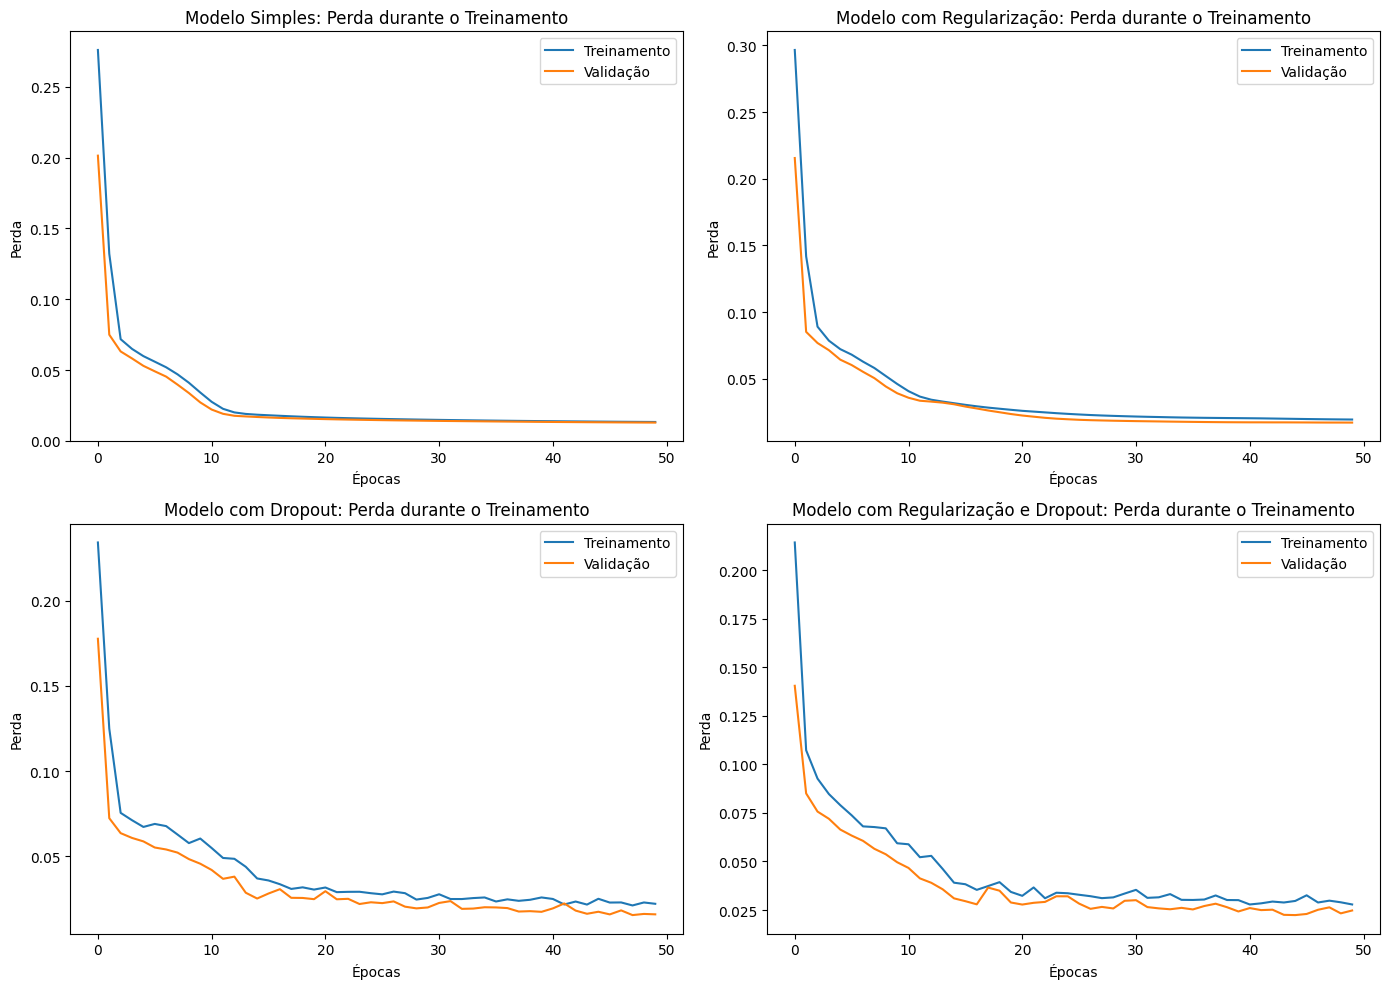

In [73]:
#Plot do Grafico de Perda
plot_multiple_loss(history_lstm, history_lstm_reg, history_lstm_drop, history_lstm_reg_drop)

In [74]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


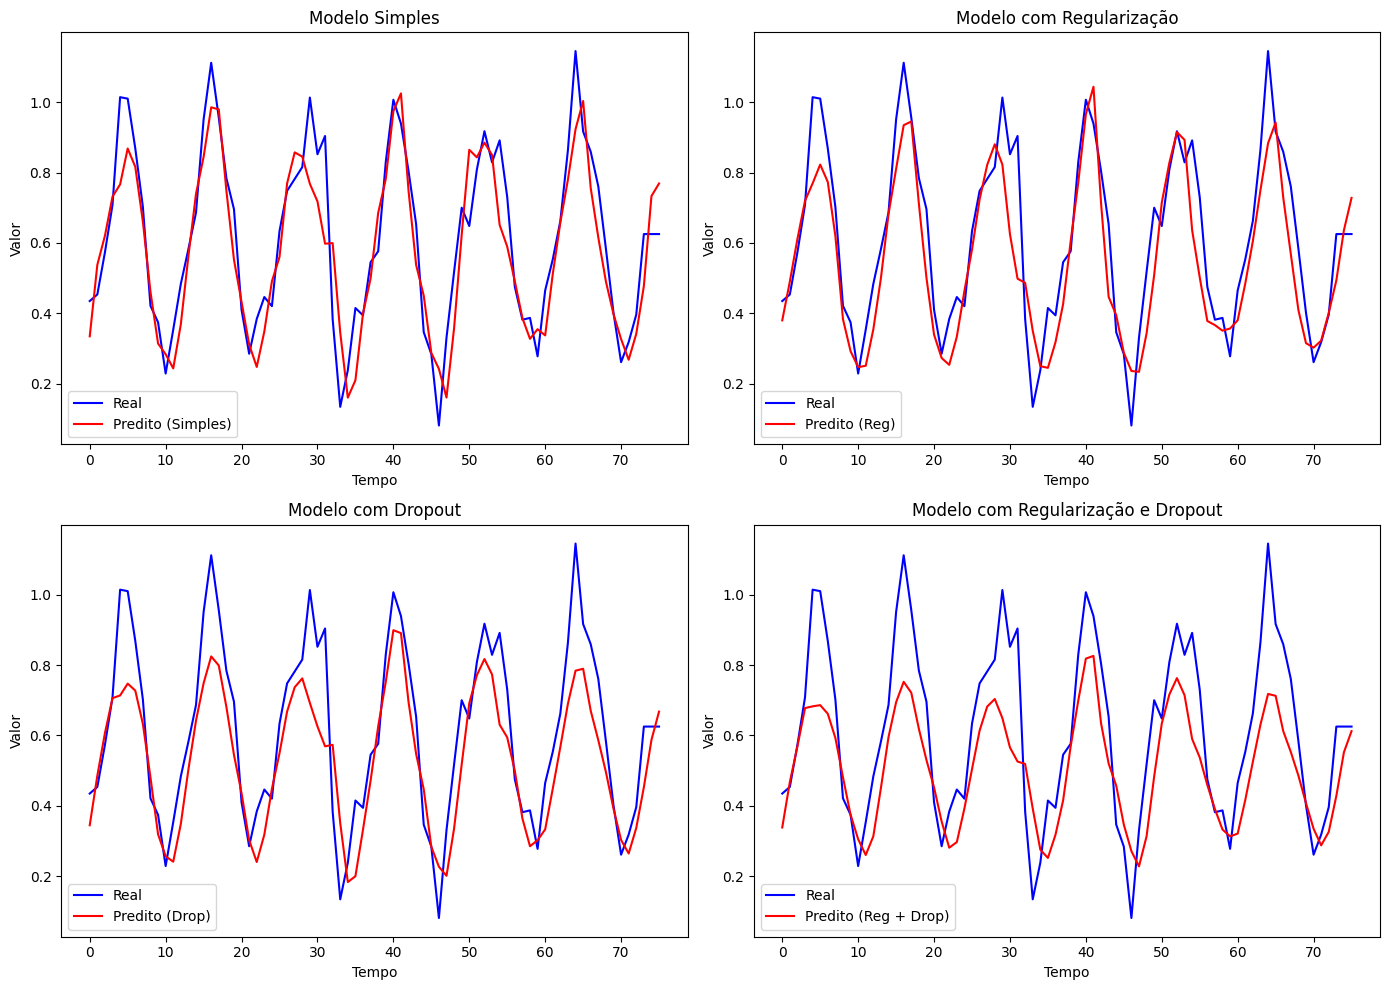

In [75]:
plot_predicts(y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop)

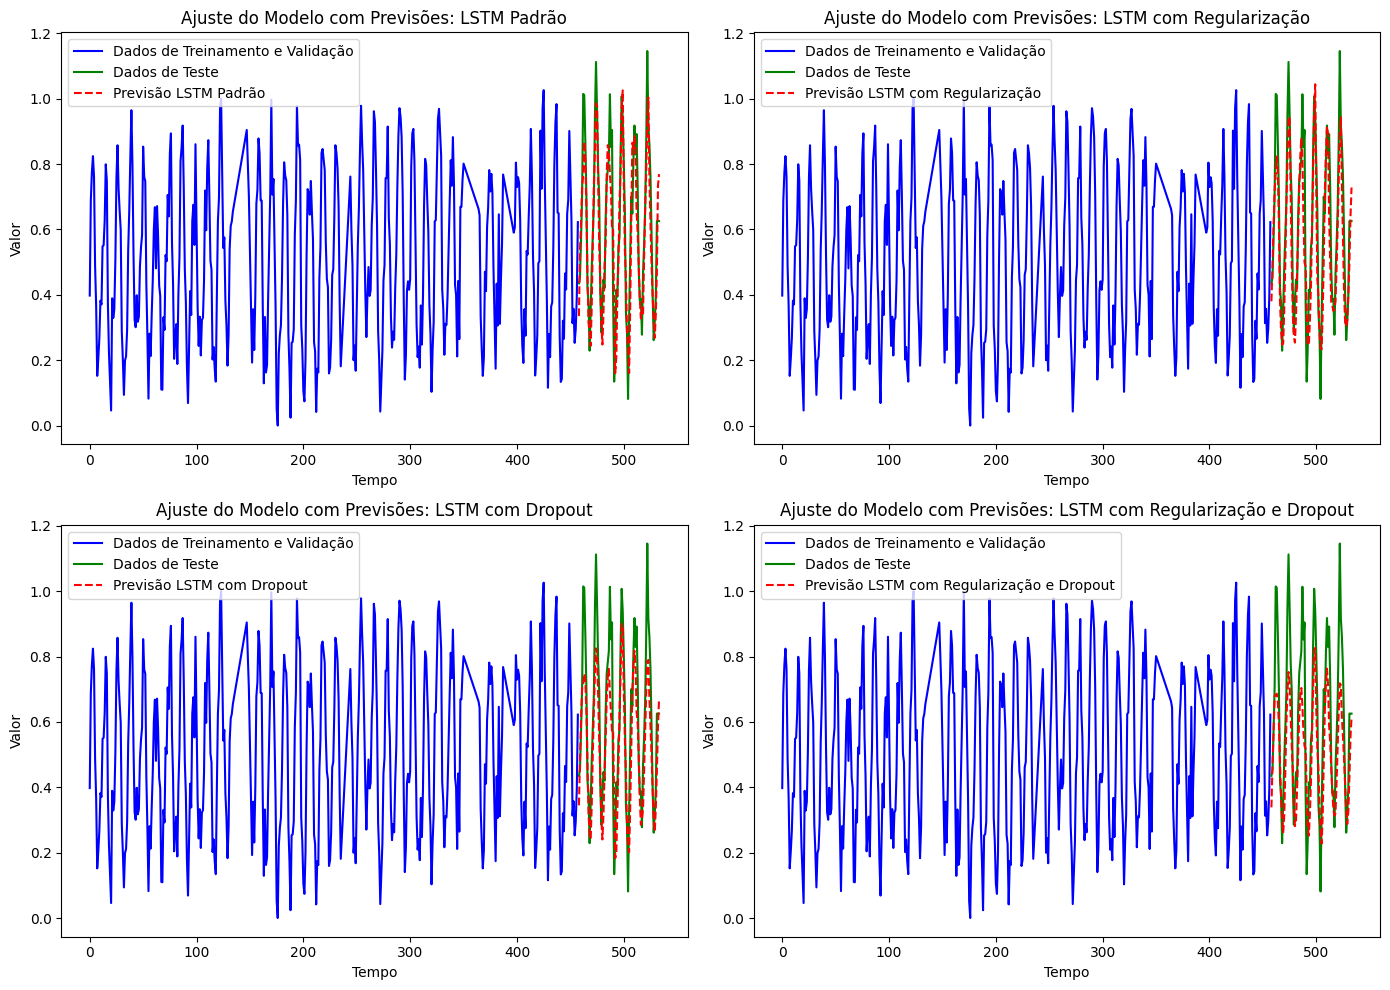

In [76]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [77]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2

In [78]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (384, 2, 5, 1)
Validation set shape (74, 2, 5, 1)
Test set shape (76, 2, 5, 1)


## Implementacao e ajuste do modelo padrao

In [79]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [80]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub,
                                      Y_train,
                                      validation_data=(X_valid_series_sub, Y_valid),
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid,
                                      verbose=1)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.3095 - val_loss: 0.2354
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1954 - val_loss: 0.1063
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0960 - val_loss: 0.0832
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0895 - val_loss: 0.0739
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0806 - val_loss: 0.0733
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0792 - val_loss: 0.0700
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0773 - val_loss: 0.0685
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0752 - val_loss: 0.0668
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0734 - val_loss: 0.0647
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0714 - val_loss: 0.0628
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0692 - val_loss: 0.0603
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0666 - val_l

## Implementacao e Ajuste do modelo com Regularizacao

In [81]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [82]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub,
                                              Y_train,
                                              validation_data=(X_valid_series_sub, Y_valid),
                                              epochs=epochs_hibrid,
                                              batch_size = batch_hibrid,
                                              verbose=1)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.4402 - val_loss: 0.2548
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2598 - val_loss: 0.2031
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1998 - val_loss: 0.1661
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1646 - val_loss: 0.1331
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1354 - val_loss: 0.1110
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1138 - val_loss: 0.0942
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0975 - val_loss: 0.0805
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0837 - val_loss: 0.0687
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0712 - val_loss: 0.0567
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0577 - val_loss: 0.0451
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0460 - val_loss: 0.0406
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0406 - val_l

## Implementacao e Ajuste do Modelo com Dropout

In [83]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(LSTM(50, activation='relu'))
model_cnn_lstm_drop.add(Dropout(0.3))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [84]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub,
                                                Y_train,
                                                validation_data=(X_valid_series_sub, Y_valid),
                                                epochs=epochs_hibrid,
                                                batch_size = batch_hibrid,
                                                verbose=1)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2290 - val_loss: 0.0734
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1015 - val_loss: 0.0684
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0822 - val_loss: 0.0647
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0766 - val_loss: 0.0569
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0681 - val_loss: 0.0547
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0616 - val_loss: 0.0458
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0545 - val_loss: 0.0376
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0465 - val_loss: 0.0284
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0337 - val_loss: 0.0186
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275 - val_loss: 0.0158
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245 - val_loss: 0.0146
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232 - val_l

## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [85]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(0.3))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub,
                                                        Y_train,
                                                        validation_data=(X_valid_series_sub, Y_valid),
                                                        epochs=epochs_hibrid,
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.4833 - val_loss: 0.2611
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2785 - val_loss: 0.2112
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2168 - val_loss: 0.1774
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1822 - val_loss: 0.1439
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1571 - val_loss: 0.1229
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1301 - val_loss: 0.1058
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1146 - val_loss: 0.0904
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1009 - val_loss: 0.0777
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0866 - val_loss: 0.0644
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0723 - val_loss: 0.0545
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0606 - val_loss: 0.0470
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0563 - val_l

## Comparativo entre os modelos

In [86]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


In [87]:
# # Cálculo das métricas para cada modelo
# metrics = {
#     "Modelo LSTM": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm)
#     },
#     "Modelo LSTM com Regularização": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg)
#     },
#     "Modelo LSTM com Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_drop)
#     },
#     "Modelo LSTM com Regularização e Dropout": {
#         "MAPE": mean_absolute_percentage_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "MSE": mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop),
#         "RMSE": root_mean_squared_error(Y_test, y_pred_cnn_lstm_reg_drop)
#     }
# }

# # Exibir as métricas
# for model, values in metrics.items():
#     print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")

In [88]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo Padrão:
MAE: 0.1175
MSE: 0.0218
RMSE: 0.1478
MAPE: 23.6935%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo com Regularização:
MAE: 0.0913
MSE: 0.0129
RMSE: 0.1136
MAPE: 19.5220%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Modelo com Dropout:
MAE: 0.0962
MSE: 0.0144
RMSE: 0.1201
MAPE: 19.9499%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Modelo com Regularização e Dropout:
MAE: 0.1013
MSE: 0.0166
RMSE: 0.1290
MAPE: 20.9465%


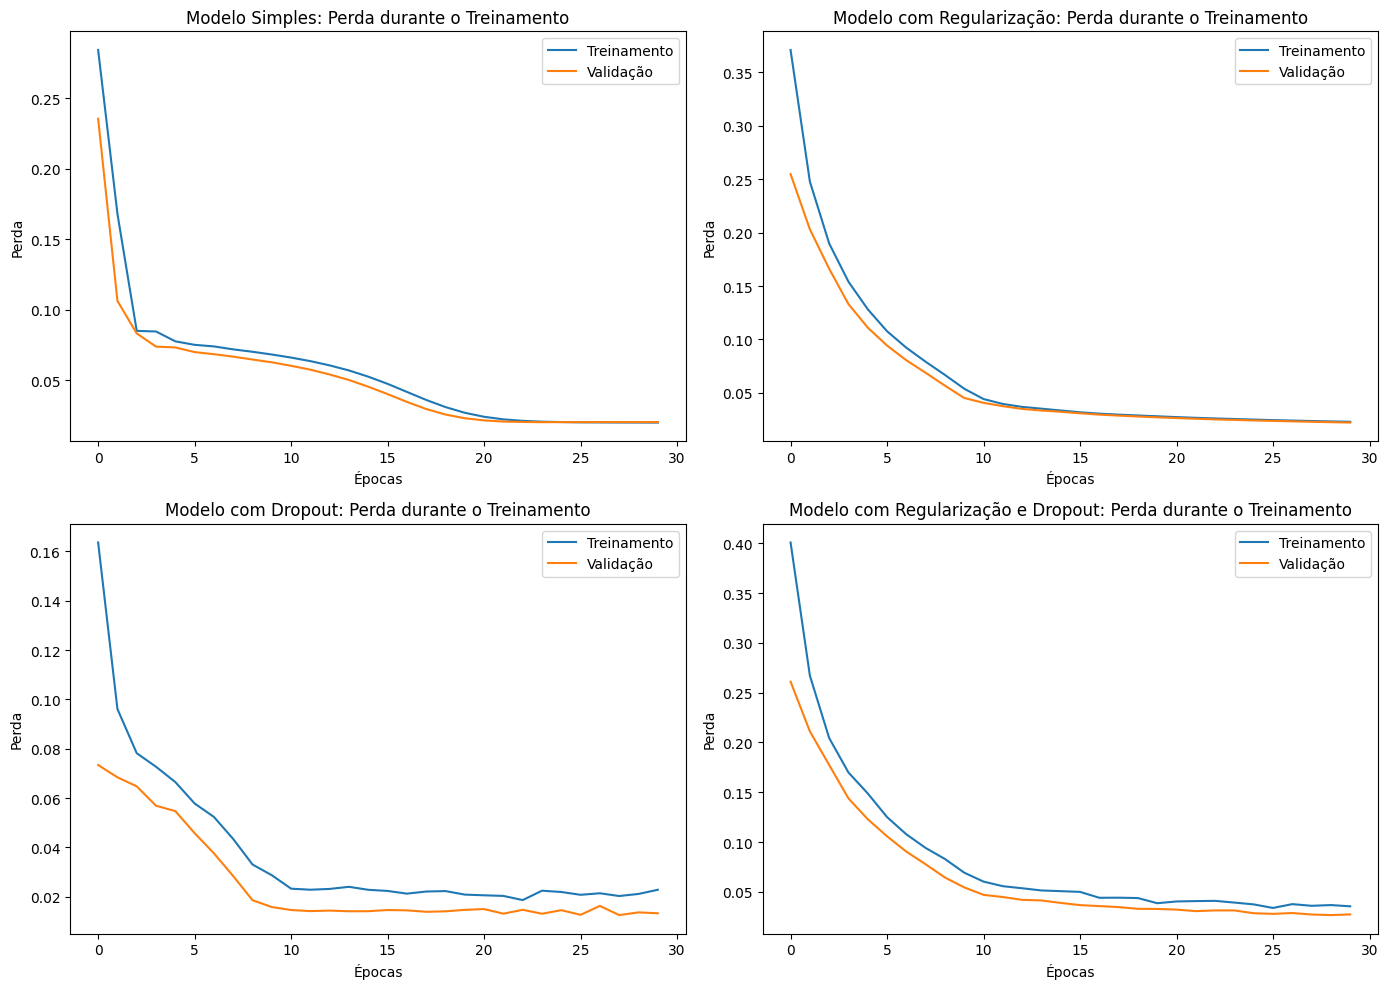

In [89]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn_lstm, history_cnn_lstm_reg, history_cnn_lstm_drop, history_cnn_lstm_reg_drop)

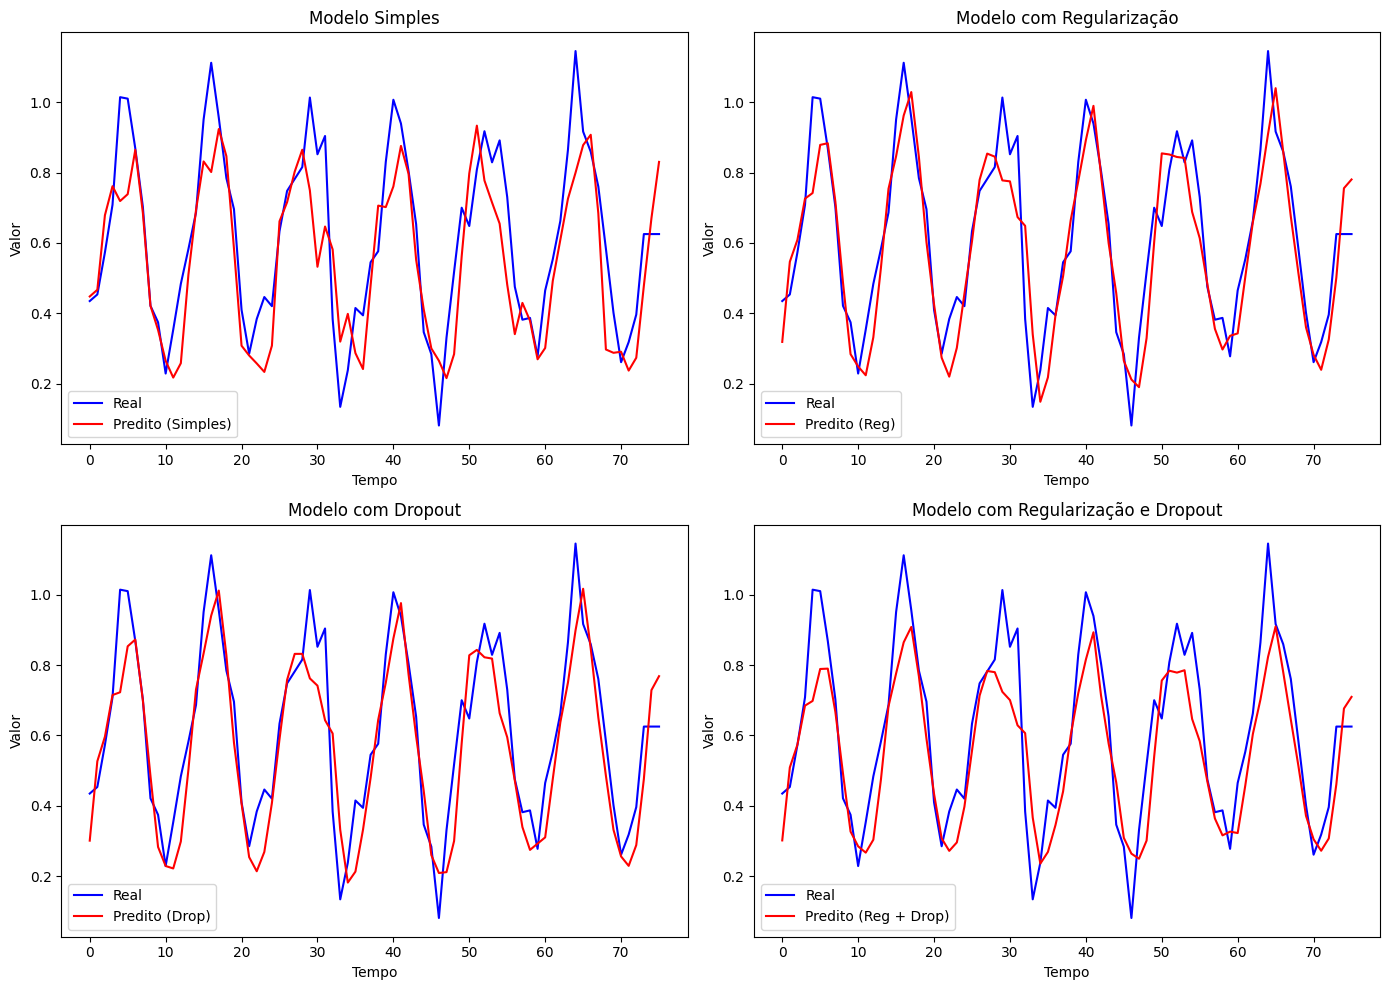

In [90]:
plot_predicts(y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop)

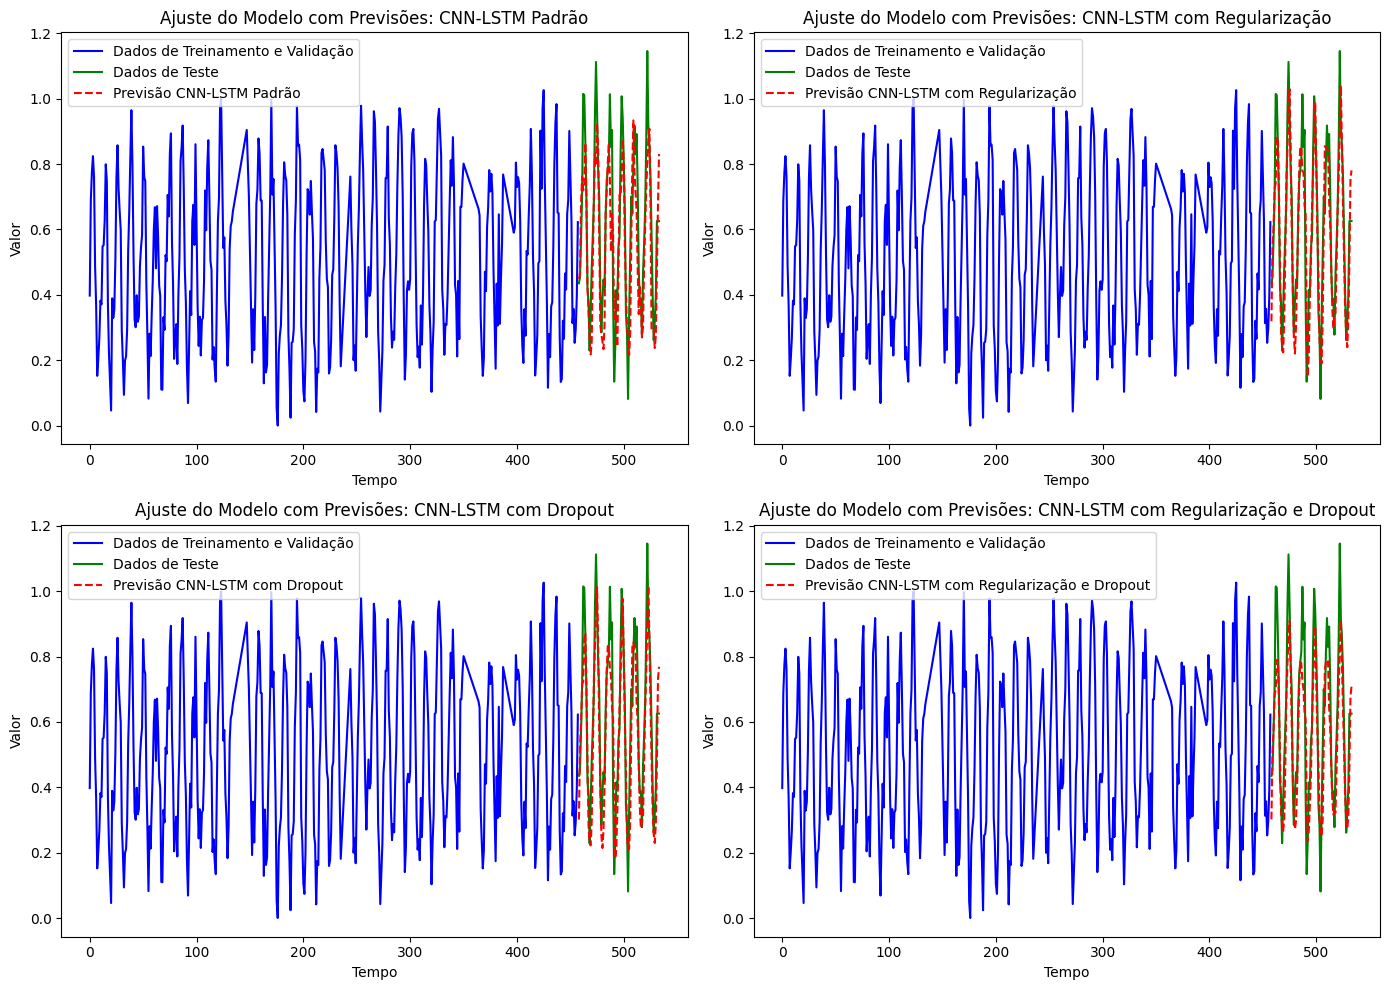

In [91]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)